# LoRA on MNIST  
1. Build an MLP. Train this model to perform well on MNIST 0-4 (half of the data).
3. Use standard finetuning approach to train this model to work on MNIST 5-9 (this will act as our baseline)
4. Use LoRA finetuning to train the original model to work on MNIST 5-9
5. Compare finetuning techniques (performance, memory etc)


Sources:
1. https://arxiv.org/abs/2106.09685 - LoRA paper
2. https://lightning.ai/pages/community/tutorial/lora-llm/ - (The first half offers useful starter pseudocode)
3. https://colab.research.google.com/drive/1iERDk94Jp0UErsPf7vXyPKeiM4ZJUQ-a?usp=sharing#scrollTo=WuK0lPwcB7Ia - had some good ideas on metrics to compute about LoRA-ized model
4. https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/mnist-hello-world.html - starter code for building an MLP and training on MNIST
5. https://discuss.pytorch.org/t/how-to-use-one-class-of-number-in-mnist/26276/21 - forum post on how to limit MNIST to only first or second half

In [1]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import LearningRateFinder
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from pytorch_lightning import Callback
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

from torchmetrics import Accuracy

import pandas as pd
import seaborn as sn
import math
import matplotlib.pyplot as plt

# set precision to what lightning suggests for this gpu
torch.set_float32_matmul_precision('high')
# make results reproducible
L.seed_everything(42)

Seed set to 42


42

In [2]:
# reserved for constants
PATH_DATASETS = 'data'


Train an MLP on the first half of MNIST

In [4]:
class LitMNIST(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, lr=2e-4):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.lr = lr

        # Hardcode some dataset specific attributes
        self.class_names = [0,1,2,3,4]
        self.min_class = min(self.class_names)
        self.num_classes = len(self.class_names) 
        self.dims = (1, 28, 28) # the shape of an example (C x W x H)
        channels, width, height = self.dims

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.batch_size = 1024

        # Define layers for model
        self.l1 = nn.Linear(channels * width * height, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, self.num_classes)

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

        
        # Define metrics
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)


    def forward(self, x):
        # preprocessing
        x = torch.flatten(x,1)

        # layer 1 (input size, hidden size)
        x = self.l1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # layer 2 (hidden size, hidden size)
        x = self.l2(x)
        x = self.relu(x)
        x = self.dropout(x)

        #layer 3 (hidden size, self.num_classes)
        x = self.l3(x)
                    
        # notice that we return the log probabilities here as that is what nll loss expects in the training step
        return F.log_softmax(x, dim=1)

    def common_step(self, batch, batch_idx):
        # define steps all of {train, val, test} will take in one place
        x, y = batch
        # rescale y to be 0 indexed if necessary (like when we start using mnist 5-9)
        if self.min_class != 0:
            y = y - self.min_class
        
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return x,y, logits, loss
        
        

    def training_step(self, batch, batch_idx):
        _, _, _, loss = self.common_step(batch, batch_idx)
        self.log("train_loss", loss, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
    
    def configure_optimizers(self):
        # we'll use adamw to match the paper
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

    # the rest of the class is helper functions/hooks for configuring data/dataloader building
    @staticmethod
    def get_indices(dataset,class_names):
        if isinstance(dataset, torch.utils.data.dataset.Subset):
            targets = torch.tensor([dataset.dataset.targets[i] for i in dataset.indices])
        else:
            targets = dataset.targets

            
        indices =  []
        for i in range(len(targets)):
            if targets[i] in class_names:
                indices.append(i)
        return indices
        
    def create_dataloader(self,dataset):
        idx = self.get_indices(dataset, self.class_names)
        loader = DataLoader(dataset,batch_size=self.batch_size, sampler = SubsetRandomSampler(idx), num_workers=16) # Note - this necessarily shuffles the data due to the sampler we are using
        return loader

    def prepare_data(self):
        # download data
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

            

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)


    def train_dataloader(self):
        return self.create_dataloader(self.mnist_train)

    def val_dataloader(self):
        return self.create_dataloader(self.mnist_val)

    def test_dataloader(self):
        return self.create_dataloader(self.mnist_test)

        
        

        


In [6]:
model = LitMNIST()
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
-------------------------------------------------------------
54.7 K    Trainable params
0         Non-trainable params
54.7 K    Total params
0.219     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 28/28 [00:24<00:00,  1.14it/s, v_num=1, val_loss=0.112, val_acc=0.967]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 28/28 [00:24<00:00,  1.14it/s, v_num=1, val_loss=0.112, val_acc=0.967]


,train_loss,val_acc,val_loss
epoch,,,
0,NaN,0.758767,1.072168
1,0.644961,NaN,NaN
1,NaN,0.925241,0.501563
2,NaN,0.939884,0.255306
3,0.216880,NaN,NaN


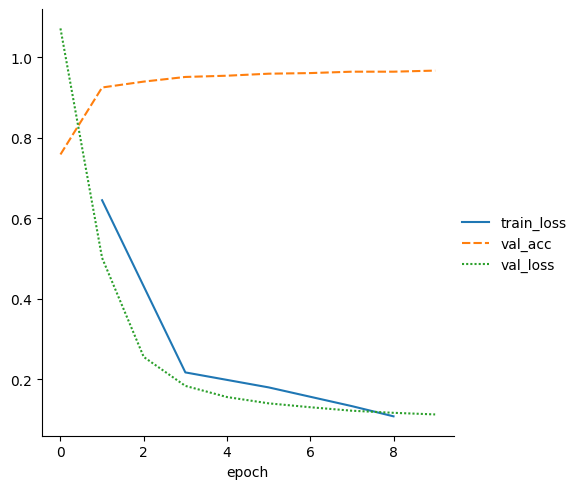

In [7]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [8]:
# as expected our model performs well
trainer.test()

/Users/keruiwu/anaconda3/envs/cpd/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/lightning_logs/version_1/checkpoints/epoch=9-step=280.ckpt
Loaded model weights from the checkpoint at logs/lightning_logs/version_1/checkpoints/epoch=9-step=280.ckpt
/Users/keruiwu/anaconda3/envs/cpd/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might g

Testing DataLoader 0: 100%|██████████| 6/6 [00:02<00:00,  2.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9735357165336609
        test_loss           0.08790729194879532
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.08790729194879532, 'test_acc': 0.9735357165336609}]

In [10]:
# save model weights so we can finetune from them later
trainer.save_checkpoint("./model.ckpt")
torch.save(model.state_dict(), './model.pt')

# Finetune on second half of MNIST

In [11]:
# load the model - we refer to it as "no training" as we are going to use this initialization to show that the model performs poorly on the second half of mnist (as it wasn't trained on it)
model_loaded_no_training = LitMNIST.load_from_checkpoint(checkpoint_path="model.ckpt")

In [12]:
# set it up to run on the second half of mnist (digits 5,6,7,8,9)
model_loaded_no_training.class_names= [5,6,7,8,9]
model_loaded_no_training.min_class = min(model_loaded_no_training.class_names)

In [13]:
# we will train on the new data on exactly one element once (this is so we can access the trainer2.test() function, which allows us to easily evaluate how well our model works on the new data prior to training)
model_loaded_no_training.batch_size = 1
trainer_no_train = L.Trainer(
    accelerator="auto",
    devices=1,
    max_steps=1,
    logger=CSVLogger(save_dir="logs/"),
)
trainer_no_train.fit(model_loaded_no_training)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
-------------------------------------------------------------
54.7 K    Trainable params
0         Non-trainable params
54.7 K    Total params
0.219     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/keruiwu/anaconda3/envs/cpd/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/Users/keruiwu/anaconda3/envs/cpd/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/keruiwu/anaconda3/envs/cpd/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:   0%|          | 1/26957 [00:10<76:16:09,  0.10it/s, v_num=2]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0:   0%|          | 1/26957 [00:10<76:22:25,  0.10it/s, v_num=2]


In [14]:
# we can see our model performs extremely poorly on the new data that it hasn't seen, which is unsuprising. 
trainer_no_train.test()

/Users/keruiwu/anaconda3/envs/cpd/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/lightning_logs/version_2/checkpoints/epoch=0-step=1.ckpt
Loaded model weights from the checkpoint at logs/lightning_logs/version_2/checkpoints/epoch=0-step=1.ckpt
/Users/keruiwu/anaconda3/envs/cpd/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 4861/4861 [00:22<00:00, 219.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3462250530719757
        test_loss           2.7943942546844482
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.7943942546844482, 'test_acc': 0.3462250530719757}]

In [15]:
# now finetune e2e on the new data
model_5_9 = LitMNIST.load_from_checkpoint(checkpoint_path="model.ckpt")
# set it up to run on the second half of mnist (digits 5,6,7,8,9)
model_loaded_no_training.class_names= [5,6,7,8,9]
model_loaded_no_training.min_class = min(model_loaded_no_training.class_names)

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model_5_9)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
-------------------------------------------------------------
54.7 K    Trainable params
0         Non-trainable params
54.7 K    Total params
0.219     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


/Users/keruiwu/anaconda3/envs/cpd/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 28/28 [00:27<00:00,  1.04it/s, v_num=3, val_loss=0.0728, val_acc=0.977]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 28/28 [00:27<00:00,  1.04it/s, v_num=3, val_loss=0.0728, val_acc=0.977]


In [13]:
# unsuprisingly finetuning allows us to perform equally well on the second half of MNIST. However this approach would require us to save the ENTIRE model binary for each dataset we wanted to finetune our initial model on, which doesn't scale well.
trainer.test()

Restoring states from the checkpoint path at logs/lightning_logs/version_3/checkpoints/epoch=9-step=280.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/lightning_logs/version_3/checkpoints/epoch=9-step=280.ckpt


Testing DataLoader 0: 100%|███████████████████████| 6/6 [00:00<00:00, 37.82it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9844327569007874     │
│         test_loss         │   0.053532421588897705    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.053532421588897705, 'test_acc': 0.9844327569007874}]

# Finetune on second half of MNIST using LoRA

In [3]:
class LitMNISTLoRA(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, lr=2e-4, lora_rank = 8):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.lr = lr

        # Hardcode some dataset specific attributes
        self.class_names = [0,1,2,3,4]
        self.min_class = min(self.class_names)
        self.num_classes = len(self.class_names) 
        self.dims = (1, 28, 28) # the shape of an example (C x W x H)
        channels, width, height = self.dims

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.batch_size = 64
        
        # Define layers for model
        self.l1 = nn.Linear(channels * width * height, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, self.num_classes)

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

        # Define lora hyperparameters
        self.lora_rank = lora_rank # The rank 'r' for the low-rank adaptation
        self.lora_alpha = 1 # lora scaling factor
        
        # layer 1 lora layers
        self.l1_lora_A = nn.Parameter(torch.empty(channels * width * height, self.lora_rank))
        self.l1_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))

        # layer 2 lora layers
        self.l2_lora_A =  nn.Parameter(torch.empty(hidden_size, self.lora_rank))
        self.l2_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))

        # layer 3 lora layers
        self.l3_lora_A = nn.Parameter(torch.empty(hidden_size, self.lora_rank))
        self.l3_lora_B = nn.Parameter(torch.empty(self.lora_rank, self.num_classes))
        
        # Define initialization for lora layers (this ensures that the model behavior is identital to to the original model prior to finetuning)
        for n,p in self.named_parameters():
            if 'lora' in n:
                if n[-1]=='A':
                    nn.init.kaiming_uniform_(p, a=math.sqrt(5))
                elif n[-1]=='B':
                    nn.init.zeros_(p)

        # freeze non lora weights
        for n,p in self.named_parameters():
            if 'lora' not in n:
                p.requires_grad = False
        
        # Define metrics
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)


    def lora_linear(self, x, layer, lora_A, lora_B):
        # does the work of combining outputs from normal layer and lora layer for x
        # notice that h is the sum of two separate operations on x
        h = layer(x)
        h += x@(lora_A @ lora_B)*self.lora_alpha
        return h
        
    def forward(self, x):
        # preprocessing
        x = torch.flatten(x,1)
        
        # layer 1 (input size, hidden size)
        x = self.lora_linear(x, self.l1, self.l1_lora_A, self.l1_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        # layer 2 (hidden size, hidden size)
        x = self.lora_linear(x, self.l2, self.l2_lora_A, self.l2_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        #layer 3 (hidden size, self.num_classes)
        x = self.lora_linear(x, self.l3, self.l3_lora_A, self.l3_lora_B)
                    
        # notice that we return the log probabilities here as that is what nll loss expects in the training step
        return F.log_softmax(x, dim=1)

    def common_step(self, batch, batch_idx):
        # define steps all of {train, val, test} will take in one place
        x, y = batch
        # rescale y to be 0 indexed if necessary (like when we start using mnist 5-9)
        if self.min_class != 0:
            y = y - self.min_class
        
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return x,y, logits, loss
        
        

    def training_step(self, batch, batch_idx):
        _, _, _, loss = self.common_step(batch, batch_idx)
        self.log("train_loss", loss, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        self.log("val_loss", loss, prog_bar=False)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
    
    def configure_optimizers(self):
        # we'll use adamw to match the paper
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

        return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": scheduler,
            "monitor": "val_loss",
            "frequency": 1
        },
        }

      
    # the rest of the class is helper functions/hooks for configuring data/dataloader building
    @staticmethod
    def get_indices(dataset,class_names):
        if isinstance(dataset, torch.utils.data.dataset.Subset):
            targets = torch.tensor([dataset.dataset.targets[i] for i in dataset.indices])
        else:
            targets = dataset.targets

            
        indices =  []
        for i in range(len(targets)):
            if targets[i] in class_names:
                indices.append(i)
        return indices
        
    def create_dataloader(self,dataset):
        idx = self.get_indices(dataset, self.class_names)
        loader = DataLoader(dataset,batch_size=self.batch_size, sampler = SubsetRandomSampler(idx), num_workers=16) # Note - this necessarily shuffles the data due to the sampler we are using
        return loader

    def prepare_data(self):
        # download data
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return self.create_dataloader(self.mnist_train)

    def val_dataloader(self):
        return self.create_dataloader(self.mnist_val)

    def test_dataloader(self):
        return self.create_dataloader(self.mnist_test)

In [7]:
# try lora finetuning with different lora ranks
def lora_experiment(rank):
    state_dict = torch.load("model.pt")
    model = LitMNISTLoRA(lora_rank=rank,)
    model.load_state_dict(state_dict, strict=False)
    model.class_names= [5,6,7,8,9]
    model.min_class = min(model.class_names)
    
    from lightning.pytorch.callbacks import LearningRateMonitor
    lr_monitor = LearningRateMonitor(logging_interval='step')
    
    trainer = L.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=10,
        callbacks=[lr_monitor, EarlyStopping(monitor="val_loss", mode="min", patience=10)],

        enable_progress_bar=True
    )
    
    trainer.fit(model)
    return trainer.test()[0]['test_acc']

In [8]:
results = {}
for rank in [8, 16]:
    result = lora_experiment(rank)
    results[rank] = result
    print(results)
    

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 8.4 K  | n/a  
-------------------------------------------------------------
8.4 K     Trainable params
54.7 K    Non-trainable params
63.1 K    Total params
0.252     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/keruiwu/anaconda3/envs/cpd/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/Users/keruiwu/anaconda3/envs/cpd/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/keruiwu/anaconda3/envs/cpd/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 9: 100%|██████████| 422/422 [00:33<00:00, 12.71it/s, v_num=3, val_acc=0.953] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 422/422 [00:33<00:00, 12.70it/s, v_num=3, val_acc=0.953]


/Users/keruiwu/anaconda3/envs/cpd/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /Users/keruiwu/Documents/RPI/ML&Opt/lightning_logs/version_3/checkpoints/epoch=9-step=4220.ckpt
Loaded model weights from the checkpoint at /Users/keruiwu/Documents/RPI/ML&Opt/lightning_logs/version_3/checkpoints/epoch=9-step=4220.ckpt
/Users/keruiwu/anaconda3/envs/cpd/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 76/76 [00:01<00:00, 54.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9491873979568481
        test_loss           0.15563635528087616
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 16.7 K | n/a  
-------------------------------------------------------------
16.7 K    Trainable params
54.7 K    Non-trainable params
71.4 K    Total params
0.286     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


{8: 0.9491873979568481}
Epoch 9: 100%|██████████| 422/422 [00:34<00:00, 12.20it/s, v_num=4, val_acc=0.958]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 422/422 [00:34<00:00, 12.19it/s, v_num=4, val_acc=0.958]


Restoring states from the checkpoint path at /Users/keruiwu/Documents/RPI/ML&Opt/lightning_logs/version_4/checkpoints/epoch=9-step=4220.ckpt
Loaded model weights from the checkpoint at /Users/keruiwu/Documents/RPI/ML&Opt/lightning_logs/version_4/checkpoints/epoch=9-step=4220.ckpt


Testing DataLoader 0: 100%|██████████| 76/76 [00:01<00:00, 70.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9561818838119507
        test_loss           0.13809379935264587
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{8: 0.9491873979568481, 16: 0.9561818838119507}


## Analysis

| Model                      | Approx. Number of Trainable Parameters | Percent Trainable Parameters Relative to Baseline | Test Accuracy            |
|----------------------------|----------------------------------------|--------------------------------------------------|---------------------------|
| Baseline - Whole Model Finetune | 54,700                                | 1.00                                           | 0.9844327569007874                        |
| LoRA Rank = 8              | 8,400                                  | 15.36%                                           | 0.949                      |
| LoRA Rank = 16             | 16,700                                 | 30.53%                                           | 0.956                      |